In [1]:
!pip install transformers torch pillow matplotlib -q

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import transformers
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

print(f"Using PyTorch version: {torch.__version__}")
print(f"Using Transformers version: {transformers.__version__}")

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")




Using PyTorch version: 2.8.0+cu126
Using Transformers version: 4.57.1
Running on device: cpu


In [3]:
# ==============================================================================
# 2. Load Model and Processor
# ==============================================================================
print("\nLoading model and processor...")
# We use a model fine-tuned for semantic segmentation on ADE20k
# model_checkpoint = "facebook/mask2former-swin-small-ade-semantic"
model_checkpoint = "facebook/mask2former-swin-large-mapillary-vistas-semantic"

processor = AutoImageProcessor.from_pretrained(model_checkpoint)
model = Mask2FormerForUniversalSegmentation.from_pretrained(model_checkpoint).to(device)
print("Model and processor loaded successfully.")


Loading model and processor...


preprocessor_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/866M [00:00<?, ?B/s]

Model and processor loaded successfully.


In [5]:
# ==============================================================================
# 3. Load and Preprocess Image
# ==============================================================================
# Load a demo image from the web
# url = ("https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg")
# image = Image.open(requests.get(url, stream=True).raw)

# url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/semantic-example.png"

from google.colab import drive
drive.mount('/content/drive')

image = Image.open("/content/drive/My Drive/input_images/0000000000.png").convert("RGB")
original_size = image.size

print(f"\nLoaded demo image with size: {original_size}")

# Preprocess the image
# We do not pad the image (pad_to_multiple_of=None) to get outputs
# that match the original image aspect ratio, which simplifies visualization.
inputs = processor(images=image, return_tensors="pt").to(device)


Mounted at /content/drive

Loaded demo image with size: (1408, 376)


In [6]:

# ==============================================================================
# 4. Perform Inference and Get Raw Logits
# ==============================================================================
print("Performing inference...")
with torch.no_grad():
    outputs = model(**inputs)

# This is the key step: Accessing the raw, pre-postprocessed logits
# class_queries_logits: [batch_size, num_queries, num_classes + 1]
# masks_queries_logits: [batch_size, num_queries, height, width]
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits
print(f"Raw class logits shape: {class_queries_logits.shape}")
print(f"Raw mask logits shape: {masks_queries_logits.shape}")


Performing inference...
Raw class logits shape: torch.Size([1, 100, 66])
Raw mask logits shape: torch.Size([1, 100, 96, 96])


In [7]:


# ==============================================================================
# 5. Compute Per-Pixel Class Probabilities
# ==============================================================================
print("Calculating per-pixel confidence map...")

# Apply Softmax to class logits to get probabilities
# We take [:, :, :-1] to exclude the "no object" class
class_probs = class_queries_logits[0].softmax(dim=-1)[:, :-1]  # Shape: [num_queries, num_classes]

# Apply Sigmoid to mask logits to get per-pixel mask probabilities
mask_probs = masks_queries_logits[0].sigmoid()  # Shape: [num_queries, height, width]

# Upsample masks to original image size
# This gives us a mask for each query at the original resolution
mask_probs_upsampled = F.interpolate(
    mask_probs.unsqueeze(0),  # Add batch dim: [1, num_queries, height, width]
    size=original_size,       # (height, width)
    mode="bilinear",
    align_corners=False
).squeeze(0)  # Remove batch dim: [num_queries, height, width]

# Combine class and mask probabilities
# We use torch.einsum for an efficient batched matrix multiplication:
# 'qc,qhw->chw'
# q = num_queries, c = num_classes, h = height, w = width
# For each class, it sums the probabilities of all queries that predict that class,
# weighted by their respective pixel masks.
per_pixel_probs = torch.einsum('qc,qhw->chw', class_probs, mask_probs_upsampled)

# Shape is now [num_classes, height, width]
print(f"Per-pixel probability map shape: {per_pixel_probs.shape}")


Calculating per-pixel confidence map...
Per-pixel probability map shape: torch.Size([65, 1408, 376])


In [8]:
# ==============================================================================
# 6. Generate Final Confidence Map
# ==============================================================================

# The "confidence" for a pixel is the probability of its *most likely* class.
# We take the max probability along the class dimension (dim=0).
# .values returns just the probabilities, .indices would return the class ID
confidence_map_tensor = torch.max(per_pixel_probs, dim=0).values

# The resulting tensor has shape [height, width]
print(f"Final confidence map shape: {confidence_map_tensor.shape}")

# Move to CPU and convert to NumPy for visualization
confidence_map_np = confidence_map_tensor.cpu().numpy()

# Also get the standard semantic segmentation map for comparison
semantic_segmentation = processor.post_process_semantic_segmentation(
    outputs, target_sizes=[original_size]
)[0]
semantic_map_np = semantic_segmentation.cpu().numpy()


Final confidence map shape: torch.Size([1408, 376])


In [9]:
# ==============================================================================
# 6.5. Inspect Class IDs
# ==============================================================================
print("\n--- Detected Class IDs and Their Meanings ---")

# Get the unique class IDs present in the segmentation map
detected_class_ids = np.unique(semantic_map_np)
print(f"Found {len(detected_class_ids)} unique class IDs in this image: {detected_class_ids}")

# Load the id2label mapping from the model's configuration
# This is a dictionary like {0: 'wall', 1: 'building', 2: 'sky', ...}
id2label = model.config.id2label

print("\nMapping:")
for class_id in detected_class_ids:
    # Use .get() for safety, defaulting to "Unknown"
    label = id2label.get(class_id, "Unknown")
    print(f"  ID {class_id} = {label}")

print("-------------------------------------------------\n")


--- Detected Class IDs and Their Meanings ---
Found 13 unique class IDs in this image: [ 2  3 13 15 17 27 29 30 33 35 45 50 55]

Mapping:
  ID 2 = Curb
  ID 3 = Fence
  ID 13 = Road
  ID 15 = Sidewalk
  ID 17 = Building
  ID 27 = Sky
  ID 29 = Terrain
  ID 30 = Vegetation
  ID 33 = Bench
  ID 35 = Billboard
  ID 45 = Pole
  ID 50 = Traffic Sign (Front)
  ID 55 = Car
-------------------------------------------------




--- Detected Class IDs, Labels, and Colors ---
Found 13 unique class IDs in this image.
Mapping (ID = Label [Hex Color]):
  ID 2 = Curb [#41004b]
  ID 3 = Fence [#670075]
  ID 13 = Road [#0000dd]
  ID 15 = Sidewalk [#004bdd]
  ID 17 = Building [#007ddd]
  ID 27 = Sky [#00a55d]
  ID 29 = Terrain [#009a08]
  ID 30 = Vegetation [#00a200]
  ID 33 = Bench [#00bf00]
  ID 35 = Billboard [#00d400]
  ID 45 = Pole [#e8f000]
  ID 50 = Traffic Sign (Front) [#ffb900]
  ID 55 = Car [#ff0900]
-------------------------------------------------



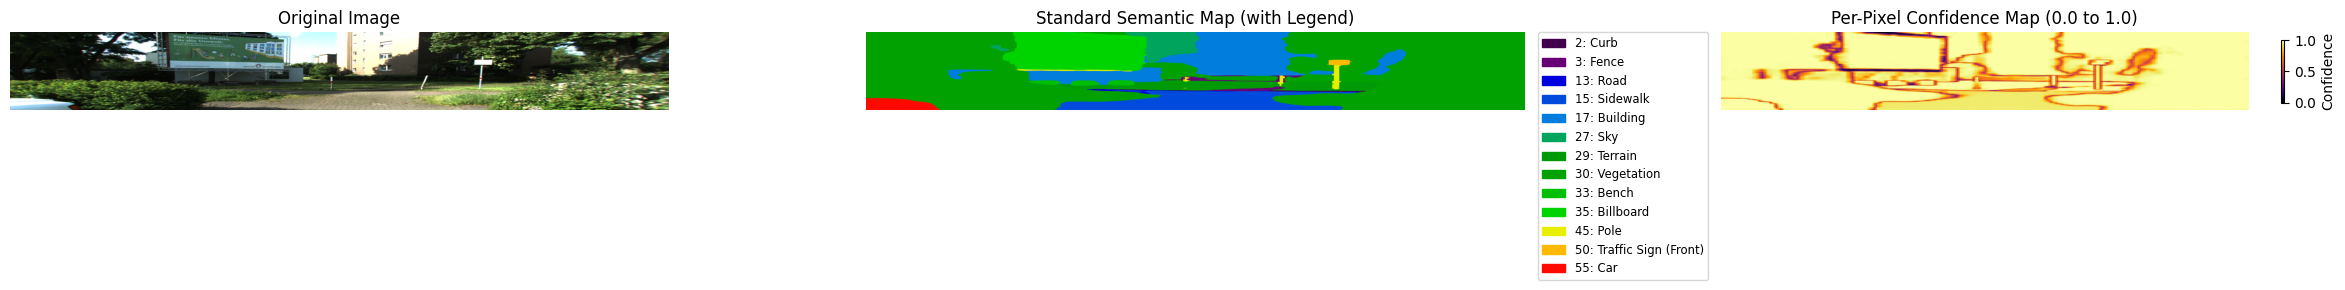


--- Demonstration Complete ---
The 'Standard Semantic Map' now has a legend on its right, mapping colors to classes.


In [10]:
# ==============================================================================
# 7. Define Colors, Print Mappings, and Visualize
# ==============================================================================
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

print("\n--- Detected Class IDs, Labels, and Colors ---")

# --- 1. Set up a Stable Colormap for ALL Classes ---
# Get the complete id-to-label mapping from the model's config
id2label = model.config.id2label
num_classes = len(id2label)

# We use a "spectral" colormap to get many visually distinct colors
# We create a list of colors, one for each of the 150 classes
# `plt.cm.nipy_spectral` is a good colormap for this
colors = [plt.cm.nipy_spectral(i / num_classes) for i in range(num_classes)]

# Create a new Matplotlib colormap and a normalization object
# This ensures that class ID 0 maps to color 0, ID 1 to color 1, etc.
custom_cmap = mcolors.ListedColormap(colors)
norm = mcolors.Normalize(vmin=0, vmax=num_classes - 1)

# --- 2. Find Detected Classes and Create Legend Patches ---
# Get the unique class IDs present *in this image*
detected_class_ids = np.unique(semantic_map_np)
legend_patches = []

print(f"Found {len(detected_class_ids)} unique class IDs in this image.")
print("Mapping (ID = Label [Hex Color]):")

for class_id in detected_class_ids:
    # Get the label name
    label = id2label.get(class_id, "Unknown")

    # Get the color for this class ID using our new colormap
    color = custom_cmap(norm(class_id))

    # Print the mapping
    print(f"  ID {class_id} = {label} [{mcolors.to_hex(color)}]")

    # Create a "patch" for the legend
    patch = mpatches.Patch(color=color, label=f"{class_id}: {label}")
    legend_patches.append(patch)

print("-------------------------------------------------\n")

# --- 3. Visualize the Results (with Correct Aspect Ratio and Legend) ---

# Get original image dimensions to calculate the correct aspect ratio
W, H = original_size
ncols = 3
nrows = 1

# Calculate the figure size to maintain the original image's aspect ratio
# We make it a bit wider (e.g., 24) to give space for the legend.
fig_width = 24
aspect_ratio = H / W
fig_height = fig_width * (nrows * aspect_ratio) / ncols

# Create the subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))

# Plot Original Image
axs[0].imshow(image, aspect='auto')
axs[0].set_title("Original Image")
axs[0].axis('off')

# Plot Standard Semantic Map
# We now use our custom colormap and normalization
axs[1].imshow(semantic_map_np, cmap=custom_cmap, norm=norm, aspect='auto')
axs[1].set_title(f"Standard Semantic Map (with Legend)")
axs[1].axis('off')

# Add the custom legend to the semantic map plot
# We place it outside the plot area to avoid covering the image
axs[1].legend(
    handles=legend_patches,
    bbox_to_anchor=(1.02, 1),  # Position legend to the right
    loc='upper left',
    borderaxespad=0.,
    fontsize='small'
)

# Plot Confidence Map
im = axs[2].imshow(confidence_map_np, cmap='inferno', vmin=0.0, vmax=1.0, aspect='auto')
axs[2].set_title("Per-Pixel Confidence Map (0.0 to 1.0)")
axs[2].axis('off')

# Add colorbar for the confidence map
fig.colorbar(im, ax=axs[2], shrink=0.8, label="Confidence")

# Use tight_layout to remove excess padding
# Note: You might need to run this cell twice in Colab for the layout to fully adjust
plt.tight_layout()
plt.show()

print("\n--- Demonstration Complete ---")
print("The 'Standard Semantic Map' now has a legend on its right, mapping colors to classes.")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import glob
from pathlib import Path

# ==============================================================================
# 3. Setup Input and Output Folders
# ==============================================================================
print("\nSetting up input/output directories...")


# Define directory paths using pathlib
input_dir = Path("/content/drive/My Drive/input_images")
output_dir = Path("/content/drive/My Drive/output_mappings")
output_visual_dir = output_dir / "visual_images"
output_binary_dir = output_dir / "binary_data"

# Create directories
input_dir.mkdir(exist_ok=True)
output_dir.mkdir(exist_ok=True)
output_visual_dir.mkdir(exist_ok=True)
output_binary_dir.mkdir(exist_ok=True)

print("Directory setup complete.")

# ==============================================================================
# 4. Define Stable Colormap
# ==============================================================================
# Get the complete id-to-label mapping from the model's config
id2label = model.config.id2label
num_classes = len(id2label)

# Create a stable colormap for all 150 classes
colors = [plt.cm.nipy_spectral(i / num_classes) for i in range(num_classes)]
custom_cmap = mcolors.ListedColormap(colors)
norm = mcolors.Normalize(vmin=0, vmax=num_classes - 1)

print(f"\nDefined stable colormap for {num_classes} classes.")

# ==============================================================================
# 5. Main Processing Loop (Corrected for Aspect Ratio)
# ==============================================================================
print("\n--- Starting Batch Processing ---")

# Find all .png, .jpg, and .jpeg images in the input directory
image_paths = list(input_dir.glob("*.png")) + \
              list(input_dir.glob("*.jpg")) + \
              list(input_dir.glob("*.jpeg"))

for image_path in image_paths:
    print(f"\nProcessing: {image_path.name}")
    try:
         # --- 5.5 Define Output Filenames ---
        base_filename = image_path.stem  # Gets the filename without extension

        sem_img_path = output_visual_dir / f"{base_filename}_semantic.png"
        sem_bin_path = output_binary_dir / f"{base_filename}_semantic.npy"

        conf_img_path = output_visual_dir / f"{base_filename}_confidence.png"
        conf_bin_path = output_binary_dir / f"{base_filename}_confidence.npy"

        if os.path.exists(sem_img_path) and os.path.exists(sem_bin_path) and os.path.exists(conf_img_path) and os.path.exists(conf_bin_path):
            print(f"\nAlready exists: {image_path.name}")
            continue


        # --- 5.1 Load and Preprocess ---
        image = Image.open(image_path).convert("RGB")

        # original_size is (width, height)
        original_size = image.size

        inputs = processor(images=image, return_tensors="pt").to(device)

        # --- 5.2 Inference and Logit Extraction ---
        with torch.no_grad():
            outputs = model(**inputs)

        class_queries_logits = outputs.class_queries_logits
        masks_queries_logits = outputs.masks_queries_logits

        # --- 5.3 Calculate Per-Pixel Probs, Confidence, and Class IDs ---
        class_probs = class_queries_logits[0].softmax(dim=-1)[:, :-1]  # [num_queries, num_classes]
        mask_probs = masks_queries_logits[0].sigmoid()                 # [num_queries, height, width]

        # ---
        # *** THE FIX IS HERE ***
        # F.interpolate expects size=(height, width)
        # We use original_size[::-1] to pass (height, width)
        # ---
        mask_probs_upsampled = F.interpolate(
            mask_probs.unsqueeze(0),
            size=original_size[::-1], # Pass (height, width)
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        # Generate the full per-pixel probability map: [num_classes, height, width]
        per_pixel_probs = torch.einsum('qc,qhw->chw', class_probs, mask_probs_upsampled)

        # A) Get the confidence map (max probability at each pixel)
        # (output shape is [height, width])
        confidence_map_tensor = torch.max(per_pixel_probs, dim=0).values

        # B) Get the semantic map (class ID of the max probability)
        # (output shape is [height, width])
        semantic_map_tensor = torch.argmax(per_pixel_probs, dim=0)

        # --- 5.4 Convert to NumPy ---
        confidence_map_np = confidence_map_tensor.cpu().numpy()
        semantic_map_np = semantic_map_tensor.cpu().numpy()

        # --- 5.6 Save Files ---

        # Save BINARY formats (raw data)
        # The arrays are (height, width), which is correct.
        np.save(sem_bin_path, semantic_map_np.astype(np.uint8))
        np.save(conf_bin_path, confidence_map_np.astype(np.float32))

        # Save IMAGE formats (visuals) using PIL

        # 1. Save Semantic Map:
        # custom_cmap turns (H, W) array into (H, W, 4) RGBA array
        semantic_rgba = (custom_cmap(norm(semantic_map_np)) * 255).astype(np.uint8)
        # Image.fromarray correctly interprets (H, W, 4) and saves
        Image.fromarray(semantic_rgba).save(sem_img_path)

        # 2. Save Confidence Map:
        inferno_cmap = plt.get_cmap('inferno')
        # inferno_cmap turns (H, W) array into (H, W, 4) RGBA array
        confidence_rgba = (inferno_cmap(confidence_map_np) * 255).astype(np.uint8)
        # Image.fromarray correctly interprets (H, W, 4) and saves
        Image.fromarray(confidence_rgba).save(conf_img_path)

        print(f"Successfully saved mappings for {image_path.name}")

    except Exception as e:
        print(f"!!! Failed to process {image_path.name}: {e}")

print("\n--- Batch Processing Complete ---")

# ==============================================================================
# 6. Verify Output Files
# ==============================================================================
print("\n--- Verifying Output Files ---")

print("\nListing contents of output_mappings/ directory:")
# Use !ls to show the file tree in Colab
!ls -lR output_mappings/

print("\n--- Testing: Loading a saved binary file ---")
# Demonstrate loading one of the saved binary files
try:
    # Pick the last processed image's .npy files
    test_sem_path = sem_bin_path
    test_conf_path = conf_bin_path

    if test_sem_path.exists() and test_conf_path.exists():
        loaded_semantic_map = np.load(test_sem_path)
        loaded_confidence_map = np.load(test_conf_path)

        print(f"Successfully loaded: {test_sem_path.name}")
        print(f"  > Semantic map shape: {loaded_semantic_map.shape}, Dtype: {loaded_semantic_map.dtype}")

        print(f"Successfully loaded: {test_conf_path.name}")
        print(f"  > Confidence map shape: {loaded_confidence_map.shape}, Dtype: {loaded_confidence_map.dtype}")

    else:
        print("Could not find .npy files to load for verification.")

except Exception as e:
    print(f"Error during verification: {e}")

print("\n--- Demonstration Complete ---")


Setting up input/output directories...
Directory setup complete.

Defined stable colormap for 65 classes.

--- Starting Batch Processing ---

Processing: 0000000024.png

Already exists: 0000000024.png

Processing: 0000000021.png

Already exists: 0000000021.png

Processing: 0000000029.png

Already exists: 0000000029.png

Processing: 0000000025.png

Already exists: 0000000025.png

Processing: 0000000015.png

Already exists: 0000000015.png

Processing: 0000000023.png

Already exists: 0000000023.png

Processing: 0000000022.png

Already exists: 0000000022.png

Processing: 0000000027.png

Already exists: 0000000027.png

Processing: 0000000017.png

Already exists: 0000000017.png

Processing: 0000000028.png

Already exists: 0000000028.png

Processing: 0000000020.png

Already exists: 0000000020.png

Processing: 0000000014.png

Already exists: 0000000014.png

Processing: 0000000018.png

Already exists: 0000000018.png

Processing: 0000000026.png

Already exists: 0000000026.png

Processing: 00000